# McCabe Thiele Method Implementation

This notebook helps the development of the McCabe-Thiele method implementation

In [11]:
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# append additional module
sys.path.append('../modules/')
from thermodynamics.equilibrium import EquilibriumCurve

# supress warnings
warnings.filterwarnings('ignore')

# load equilibrium data
elv_data = pd.read_csv('../data/equilibrium_curve_data.csv')

# create instance of the data
elv = EquilibriumCurve()

# constants
xD = 0.95       # benzene molar fraction at distillate
xB = 0.10       # benzene molar fraction at bottom product
zF = 0.45       # benzene molar fraction at feed
r = 4           # reflux ratio
Cp = 159        # feed heat capacity (J/mol.K)
Hvap = 32.099   # feed enthalpy of vaporization (kJ/mol)
Tf = 327.6      # temperature of the feed [K]
Pf = 101.3      # pressure of the feed [kPa]

In [12]:
# calculate the vapor pressure of the mixture
Pvap = zF * elv.calculate_Pvap(Tf, 'benzene') + (1 - zF) * elv.calculate_Pvap(Tf, 'toluene')
Pvap

27.310532216120166

Since the vapor pressure of the system is lower than the pressure of the system, the feed is in subcooled liquid state. We'll adopt 298.15 K as the reference temperature. We'll also assume that the enthalpy of vaporization is constant over the temperature range.

In [13]:
# calculate the enthalpy of the vapor, and the feed
Hv = Hvap
HF = (Cp / 1000) * (Tf - 298.15)

In [14]:
# calculate q
q = (Hv - HF) / Hvap
q

0.8541216237265956

In [15]:
# calculate the q-line
m_q = q / (q - 1)
b_q = zF / (q - 1)

# coordinates for the q line
q_1 = [zF, 0.2]
q_2 = [m_q * zF - b_q, m_q * 0.2 - b_q]

In [16]:
# calculate enrichment operation curve
m = r / (r + 1)
b = xD / (r + 1)

eoc1 = [xD, zF]
eoc2 = [xD, m * zF + b]

In [17]:
# calculate stripping operation curve
soc1 = [xB, zF]
soc2 = [xB, m * zF + b]

In [18]:
#function to find interpolation pair
def find_interpolation_pair(data: pd.DataFrame, x: float) -> list:
    """
    finds the interpolation pair necessary to 
    create the "touch point" between operation curve and 
    equilibrium curve

    Parameters
    ----------
    data : pd.DataFrame
        equilibrium data
    x : float
        point to be interpolated

    Returns
    -------
    list
        coordinates of the interpolation
        pair
    """

    # iterate between y values and check if the desired values
    # is between them
    for i in range(data.shape[0] - 1):
        ymin = data.loc[i, 'y_benzene']
        ymax = data.loc[i+1, 'y_benzene']

        if ((ymin < x) & (ymax > x)):
            
            xmin = data.loc[i, 'x_benzene']
            xmax = data.loc[i+1, 'x_benzene']

            return [[xmin, ymin], [xmax, ymax]]

    return None

# interpolate data
def interpolate(interpolation_pair: list, y: float) -> float:
    """
    interpolates the equilibrium curve to find next
    composition of liquid phase

    Parameters
    ----------
    interpolation_pair : list
        interpolation pair of the equilibrium curve
    y : float
        vapor molar fraction to be interpolated

    Returns
    -------
    float
        molar fraction of liquid phase 
        of the next stage
    """
    
    # extract interpolation points
    xmin = interpolation_pair[0][0]
    ymin = interpolation_pair[0][1]
    xmax = interpolation_pair[1][0]
    ymax = interpolation_pair[1][1]

    # interpolate point
    x = xmin + (((y - ymin) * (xmax - xmin)) / (ymax - ymin))

    return x

In [19]:
pair = find_interpolation_pair(data=elv_data, x=xD)
x_n = interpolate(pair, xD)
x_n

0.8808462790014723

In [20]:
mccabe_curve = pd.DataFrame([[xD, xD]], columns=['x', 'y'], index=[0])
mccabe_curve

,x,y
0,0.95,0.95


In [21]:
mccabe_curve.loc[1, :] = [x_n, xD]
mccabe_curve.loc[2, :] = [x_n, (m * x_n + b)]
mccabe_curve

,x,y
0,0.950000,0.950000
1,0.880846,0.950000
2,0.880846,0.894677


In [24]:
pair = find_interpolation_pair(data=elv_data, x=m*x_n+b)
x_n1 = interpolate(pair, m*x_n+b)

print(pair, m,x_n1)

[[0.75, 0.8845239392290953], [0.8, 0.9111595141266507]] 0.8 0.7690592544203247


In [25]:
mccabe_curve.loc[3, :] = [x_n1, m * x_n + b]
mccabe_curve

,x,y
0,0.950000,0.950000
1,0.880846,0.950000
2,0.880846,0.894677
3,0.769059,0.894677


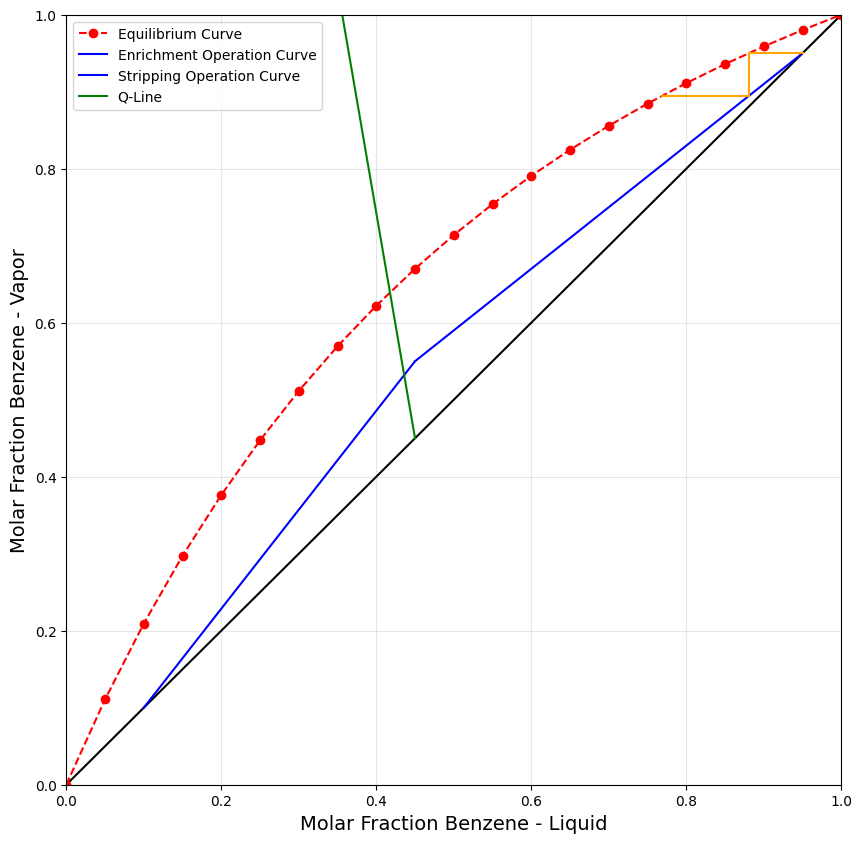

In [26]:
# plot equilibrium data
plt.figure(figsize=(10,10))
plt.plot(elv_data.x_benzene, elv_data.x_benzene, 'k-')
plt.plot(elv_data.x_benzene, elv_data.y_benzene, 'ro--', label='Equilibrium Curve')
plt.plot(eoc1, eoc2, 'b-', label='Enrichment Operation Curve')
plt.plot(soc1, soc2, 'b-', label='Stripping Operation Curve')
plt.plot(mccabe_curve.x, mccabe_curve.y, color='orange')
plt.plot(q_1, q_2, 'green', label='Q-Line')
plt.xlabel('Molar Fraction Benzene - Liquid', size=14)
plt.ylabel('Molar Fraction Benzene - Vapor', size=14)
plt.legend(loc='best')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.show()